In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from src.features import build_features_op, utils, build_features
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.visualization.visual import anomaly_plot
from src.config.config import seed_everything, cfg

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

train_data = pd.read_csv(r'data\raw\train_data.csv')
train_data = utils.outlier_z_score_filter_df(train_data)
train_data = build_features.create_derived_features(train_data)


test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features.create_derived_features(test_data)


scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_test_data = pd.DataFrame(scaled_test_data, columns=train_data.columns)

grouped_train = scaled_train_data.groupby('type')

preds = []
ths = []
train_ths = []
for group_name, group_data in grouped_train:
    test_group = scaled_test_data[scaled_test_data['type'] == group_name]
    train_group = group_data.drop('type', axis=1).values
    test_group = test_group.drop('type', axis=1).values

    n_features = train_group.shape[1]
    print(n_features)
    dataloader = DatasetLoader(train_group, test_group)
    train_loader, test_loader = dataloader.load
    model = predict_model.AutoEncoder(input_dim=n_features, latent_dim=64)
    # model = predict_model.DeepAutoEncoder(input_dim=n_features, latent_dim=64)
    # criterion = nn.MSELoss()
    # criterion = nn.L1Loss()
    criterion = nn.HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(train_loader, model, criterion, optimizer)

    train_prediction, train_cosine = evaluation(train_loader, model)
    prediction, cosine = evaluation(test_loader, model)
    
    preds.append(prediction)
    ths.append(cosine)
    train_ths.append(train_cosine)
    print(f"finish {group_name}type")

threshold = np.concatenate(ths)
preds = np.concatenate(preds)
train_threshold = np.concatenate(train_ths)
prediction_to_csv(preds)

25
Epoch [1/500], Loss: 0.1748640
Epoch [2/500], Loss: 0.1231574
Epoch [3/500], Loss: 0.0809828
Epoch [4/500], Loss: 0.0493889
Epoch [5/500], Loss: 0.0304625
Epoch [6/500], Loss: 0.0206225
Epoch [7/500], Loss: 0.0160818
Epoch [8/500], Loss: 0.0131431
Epoch [9/500], Loss: 0.0119610
Epoch [10/500], Loss: 0.0113766
Epoch [11/500], Loss: 0.0110453
Epoch [12/500], Loss: 0.0106129
Epoch [13/500], Loss: 0.0099082
Epoch [14/500], Loss: 0.0089907
Epoch [15/500], Loss: 0.0080361
Epoch [16/500], Loss: 0.0070884
Epoch [17/500], Loss: 0.0061486
Epoch [18/500], Loss: 0.0052639
Epoch [19/500], Loss: 0.0044657
Epoch [20/500], Loss: 0.0037515
Epoch [21/500], Loss: 0.0031254
Epoch [22/500], Loss: 0.0025973
Epoch [23/500], Loss: 0.0022145
Epoch [24/500], Loss: 0.0019956
Epoch [25/500], Loss: 0.0018565
Epoch [26/500], Loss: 0.0017441
Epoch [27/500], Loss: 0.0016151
Epoch [28/500], Loss: 0.0014499
Epoch [29/500], Loss: 0.0012767
Epoch [30/500], Loss: 0.0011391
Epoch [31/500], Loss: 0.0010456
Epoch [32/500]

In [2]:
tth = pd.Series(train_threshold)

In [3]:
tth.describe()

count    2405.000000
mean        0.999962
std         0.000030
min         0.999683
25%         0.999953
50%         0.999971
75%         0.999982
max         0.999997
dtype: float64

In [4]:
test_data['label'] = preds
test_data['treshold'] = threshold

In [5]:
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no

yes, no = no_out(test_data)

In [6]:
yes

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,air_flow_pressure,current_by_airflow,...,vibration_endtemp_product,rpm_airflow_product,compression_ratio,airflow_per_rotation,efficiency,air_density,volumetric_efficiency,work_input,label,treshold
7343,2.21,49.23,0.7,28.58,2338.0,65.98,3.30,7,1.547,12.932127,...,162.4590,5166.98,0.316742,0.000945,0.016403,0.007566,0.286440,220506.1320,0,0.999880
7344,2.43,52.23,0.7,31.51,2578.0,68.64,3.43,7,1.701,12.967078,...,179.1489,6264.54,0.288066,0.000943,0.015738,0.007496,0.274808,278628.4354,0,0.999966
7345,1.95,45.86,0.7,25.29,2069.0,62.99,3.15,7,1.365,12.969231,...,144.4590,4034.55,0.358974,0.000942,0.017135,0.007646,0.299201,164823.7815,0,0.999950
7346,2.87,57.99,0.7,37.14,3039.0,73.77,3.69,7,2.009,12.940767,...,213.9831,8721.93,0.243902,0.000944,0.014659,0.007366,0.255932,416484.6174,0,0.999913
7347,1.27,36.78,0.7,16.40,1342.0,54.91,2.75,7,0.889,12.913386,...,101.1450,1704.34,0.551181,0.000946,0.019712,0.007870,0.344127,60524.2000,0,0.999919
7349,1.32,37.51,0.7,17.12,1401.0,55.57,2.78,7,0.924,12.969697,...,104.2778,1849.32,0.530303,0.000942,0.019414,0.007851,0.338915,66678.6336,0,0.999938
7350,3.05,60.43,0.7,39.53,3234.0,75.93,3.80,7,2.135,12.960656,...,229.6340,9863.70,0.229508,0.000943,0.014213,0.007312,0.248185,485792.0760,0,0.999956
7351,2.99,59.61,0.7,38.73,3169.0,75.21,3.76,7,2.093,12.953177,...,224.1336,9475.31,0.234114,0.000944,0.014373,0.007330,0.250935,461484.9912,0,0.999933
7352,1.22,36.16,0.7,15.80,1293.0,54.37,2.72,7,0.854,12.950820,...,98.3552,1577.46,0.573770,0.000944,0.019872,0.007885,0.346890,55567.9680,0,0.999945
7353,2.84,57.60,0.7,36.76,3008.0,73.42,3.67,7,1.988,12.943662,...,211.3920,8542.72,0.246479,0.000944,0.014736,0.007374,0.257261,405806.8736,0,0.999930


In [7]:
no

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,air_flow_pressure,current_by_airflow,...,vibration_endtemp_product,rpm_airflow_product,compression_ratio,airflow_per_rotation,efficiency,air_density,volumetric_efficiency,work_input,label,treshold
7342,1.60,45.04,0.7,24.57,1923.0,61.37,3.27,7,1.120,15.356250,...,147.2808,3076.80,0.437500,0.000832,0.013940,0.007665,0.254444,154501.3197,1,0.636915
7348,2.76,62.36,0.7,42.28,3309.0,76.77,4.04,7,1.932,15.318841,...,251.9344,9132.84,0.253623,0.000834,0.011311,0.007270,0.206458,565214.2608,1,0.785698
7359,1.48,43.15,0.7,22.64,1772.0,59.69,3.18,7,1.036,15.297297,...,137.2170,2622.56,0.472973,0.000835,0.014390,0.007711,0.262646,127575.4944,1,0.563168
7360,1.74,47.05,0.7,26.63,2084.0,63.16,3.36,7,1.218,15.304598,...,158.0880,3626.16,0.402299,0.000835,0.013612,0.007617,0.248492,186469.6512,1,0.709030


143
0
27
38
13
32
102
4


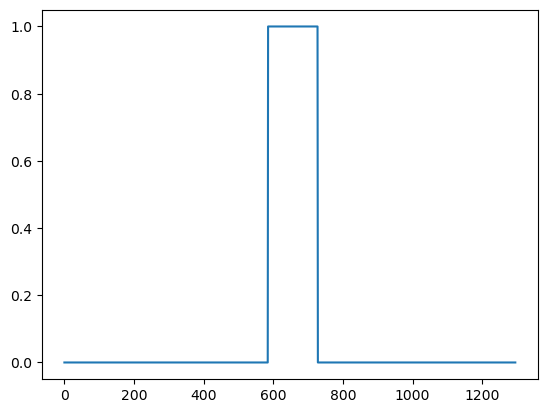

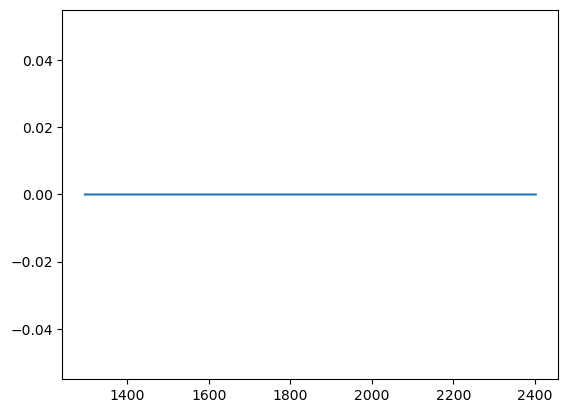

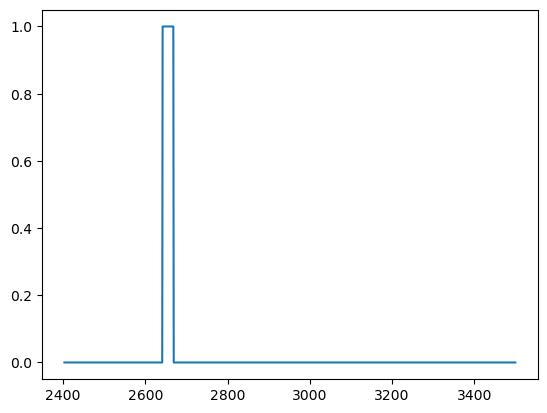

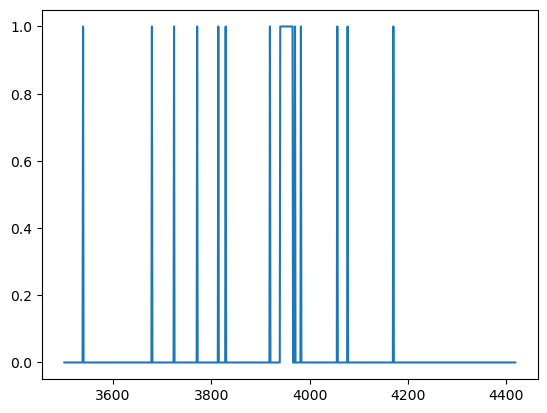

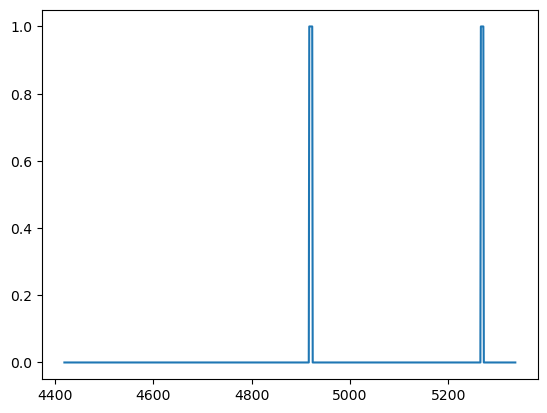

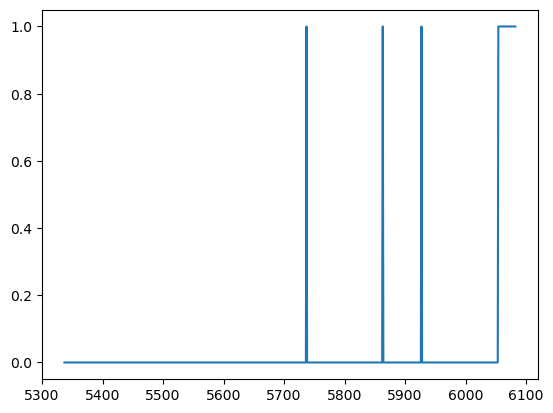

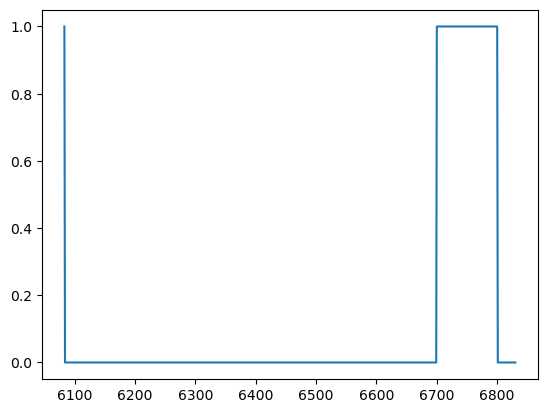

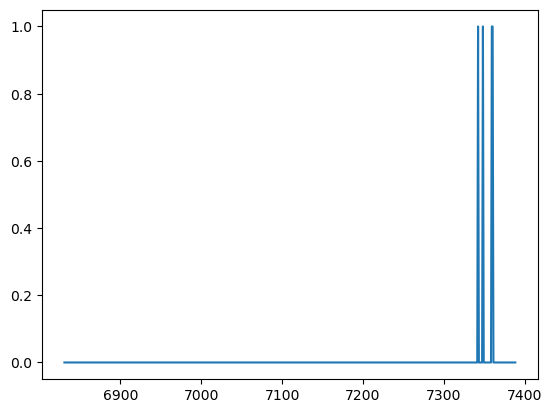

In [8]:
predictions = pd.read_csv(r"C:\Project_MB\Anomaly-Detection-of-Air-Compressor\data\submission\20230411_234643submission.csv")

predictions00 = predictions[:1296]
predictions01 = predictions[1296:2403]
predictions02 = predictions[2403:3501]
predictions03 = predictions[3501:4419]
predictions04 = predictions[4419:5337]
predictions05 = predictions[5337:6083]
predictions06 = predictions[6083:6831]
predictions07 = predictions[6831:]

print(len(predictions00[predictions00['label'] == 1]))
print(len(predictions01[predictions01['label'] == 1]))
print(len(predictions02[predictions02['label'] == 1]))
print(len(predictions03[predictions03['label'] == 1]))
print(len(predictions04[predictions04['label'] == 1]))
print(len(predictions05[predictions05['label'] == 1]))
print(len(predictions06[predictions06['label'] == 1]))
print(len(predictions07[predictions07['label'] == 1]))

predict_type = [predictions00, predictions01, predictions02, predictions03, predictions04, predictions05, predictions06, predictions07]

for type in predict_type:
    plt.plot(type['label'])
    plt.show()
    